In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# from labtools.adtools.counter import seq_counter

In [2]:
pwd

'/global/scratch/users/empchase/LC_E1_step2/LC_E1_step2_testlibs_spikein'

In [3]:
# read in spike in files
path = '/global/scratch/users/empchase/LC_E1_step2/LC_E1_step2_testlibs_spikein/'
r1f = path + 'results/Staller_RPTR_E3_v1_MVS_0066_I1_TGGCTGCTGA_GCCAGTCTGT_S3.fastq.gz.assembled.fastq'
r2f = path + 'results/Staller_RPTR_E3_v2_MVS_0068_I1_TCGAGGTTAA_CTCGCAGCAA_S5.fastq.gz.assembled.fastq'
a1f = path + 'results/Staller_AD_E1_MVS_0070_I1_TCCAGAACTC_ACGTGAGCGA_S7.fastq.gz.assembled.fastq'

#set consensus sequences

adp = 'CGGGCCC'#7 bp ; beforeAD barcode in read1
adf = 'GGCGCGC' #7bp ; after AD barcode in read1
tp = "TAGTCA" #tile
tf = "GCTAGC"

rpp = 'AGCGGCC' #7bp ; before rptr barcode in read1
rpf = 'CTCGAGT' #7 bp ; after rptr barcode in read1


In [4]:
#get list of designed tiles
a11design = path+'a11_designfile.csv'
a11dt = []

with open(a11design, 'r') as f:
    for line in f:
        if "ArrayDNA" in line:
            pass
        else:
            a11dt.append(line.strip())
print(len(a11dt))#18843

#create a dictionary of values
dtiles = {}
for i in a11dt:
    dtiles[i] = 1
    
# print(d)

18843


In [5]:
def complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N':'N', 'X':'X'} 
    bases = list(seq) 
    bases = [complement[base] for base in bases] 
    return ''.join(bases)
def reverse_complement(s):
        return complement(s[::-1])
    
    
def getmid(seq, pre, post, bclen):
    # seq = the sequence to parse
    # pre = substring that precedes piece of interest
    # post = substring that follows piece of interest
    # returns piece of interest

    re_key = pre + "(.*)"+ post 
    poi_search = re.search(re_key, seq)
    if poi_search is None:
        #the barcode will be called X
        poi = "X"
        
        #then we search for which restriction site had the error
        #regex for the bc we want to ignore
        w = "(.{"+str(bclen)+"})" 
        pre_re = pre + w + "(.{7})"
        pre_search = re.search(pre_re, seq)
        post_re = "(\w{7})" + w + post
        post_search = re.search(post_re, seq)
        
        if pre_search is None and post_search is None:
            a = 'X'
            z = 'X'
        elif pre_search is None:
            poi = post_search.group(2)
            a = post_search.group(1)
            z = post
        elif post_search is None:
            poi = pre_search.group(1)
            z = pre_search.group(2)
            a = pre
        else:
            a = "Z"
            z = 'Z'            
    else:
        poi = poi_search.group(1)
        a = pre
        z = post
    
    return poi, a, z


# function that just looks for RPTR bc
def rbc_finder(readfile, bc_pre=rpp, bc_post=rpf, bc_len=14):
    #readfile = fastq file -- RPTR files are read1
    #default values for the pre/post regions defined in above cell
    
    # make lists of reads
    seqlist = []
    with open(readfile, 'r') as fin:
        for line in fin:
            if line.startswith('@'):
                #look at next line to get read sequence, add to list
                seq = next(fin)
                seq = seq.strip()
                seqlist.append(seq)

    
    #make lists of BCs from list of reads
    bc_list = []
    bc_lens = []       
    for read in seqlist:
        bc, prex, postx = getmid(read, bc_pre, bc_post, bc_len)
        bc = reverse_complement(bc) #return reverse complement
        bc_list.append(bc)
        bcl = len(bc)
        bc_lens.append(bcl)

    #make the dict/df
    BC_dict = {"BCs":bc_list, "Length":bc_lens} 
    BC_df = pd.DataFrame.from_dict(BC_dict)
    
    #label df with library name
    libname = '_'.join(readfile.split('/')[-1].split('_')[0:6])
    BC_df['Library'] = libname
    
    return BC_df


# function that just looks for Tile/AD bc
def adbc_mapper(readfile, tile_pre = tp, tile_post = tf, 
                  adBC_pre = adp, adBC_post = adf):
    #readfile = fastq (ADBC fastqs are typically paired)
    # *_pre or *_post = the consensus sequences before or after each feature, defaults defined above

    # make lists of reads
    readlist = []    
    with open(readfile, 'r') as fin:
        for line in fin:
            if line.startswith('@'):
                #look at next line to get read sequence, add to list
                seq = next(fin)
                seq = seq.strip()
                readlist.append(seq)
                
    #make lists of tiles/BCs from list of reads
    tile_list = []
    tile_lengths= []
    
    des_query = [] # tells us if tile matches design or not
    
    adBC_list = []
    adBC_lengths = []
    
    tile_adbc = []
   
    
    for read in readlist:
        tile, tpre, tpost = getmid(read, tile_pre, tile_post, 120) #use consensus seq to find tile
        tile = reverse_complement(tile)
        tile_list.append(tile) #add tile to list
        tile_len = len(tile) #find length of tile
        tile_lengths.append(tile_len) #add length to list
            
        if tile in dtiles:
            des_query.append(1)
        else:
            des_query.append(0)
#         print(tile)
        
        adBC, prea, posta = getmid(read, adBC_pre, adBC_post, 11)
        adBC = reverse_complement(adBC)
        adBC_list.append(adBC)
        adBC_len = len(adBC)
        adBC_lengths.append(adBC_len)
        
        tile_adbc.append(tile+'-'+adBC)

            
    # make the df
    tileBC_dict = {"Tiles":tile_list, "T Len" : tile_lengths, "Designed": des_query, 
                  "AD BCs":adBC_list, "A Len": adBC_lengths, 'Tile-AD': tile_adbc}
    tileBC_df = pd.DataFrame.from_dict(tileBC_dict)
    
    libname = '_'.join(readfile.split('/')[-1].split('_')[0:6])
    tileBC_df['Library'] = libname
    
    return tileBC_df


In [6]:
rptr1_bcs = rbc_finder(r1f)
rptr1_bcs.head()

,BCs,Length,Library
0,GTAAGTATGAGTTG,14,Staller_RPTR_E3_v1_MVS_0066
1,ATGATAACGTAGCT,14,Staller_RPTR_E3_v1_MVS_0066
2,AAAAACCTCATTGC,14,Staller_RPTR_E3_v1_MVS_0066
3,CTACCCATTTTCAA,14,Staller_RPTR_E3_v1_MVS_0066
4,CTACTCCTCATTAC,14,Staller_RPTR_E3_v1_MVS_0066


In [7]:
rptr1_bcs_valuecounts = rptr1_bcs['BCs'].value_counts().to_frame().reset_index()
rptr1_bcs_valuecounts

,index,BCs
0,ACTTCTAAATAAGC,43982
1,X,1028
2,GACACACATCCTAC,656
3,GGGACGCCTGTCCT,648
4,TTAAATGTTATGCT,558
...,...,...
13763,TATCTCTGGGGCGA,1
13764,TAATAGACAAGTCC,1
13765,ACTTGGCTGCTCAA,1
13766,TTCCCTTATGCAAA,1


In [8]:
rptr1_bcs_valuecounts.describe()

,BCs
count,13768.000000
mean,21.939643
std,375.887509
min,1.000000
25%,5.000000
50%,13.000000
75%,24.000000
max,43982.000000


In [9]:
rptr1_bcs_valuecounts[rptr1_bcs_valuecounts['index']!= 'X'].sum()

index    ACTTCTAAATAAGCGACACACATCCTACGGGACGCCTGTCCTTTAA...
BCs                                                 301037
dtype: object

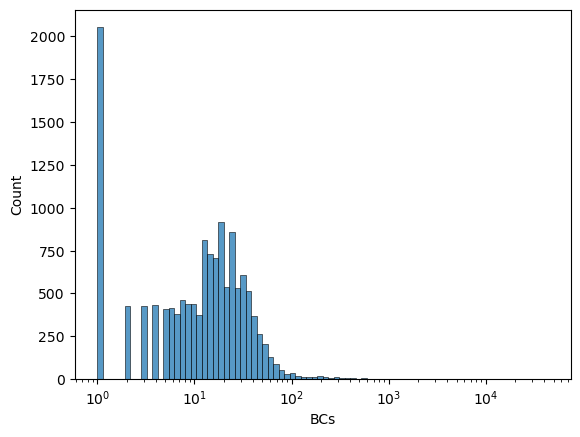

In [10]:
# plt.hist(rptr1_bcs_valuecounts['BCs'], bins=10)
# plt.ylim(0, 10)
# plt.xlim(0, 10)

sns.histplot(data=rptr1_bcs_valuecounts, x='BCs', log_scale = True)
plt.show()

In [11]:
rptr2_bcs = rbc_finder(r2f)
rptr2_bcs.head()

,BCs,Length,Library
0,TCATATCACCGTGG,14,Staller_RPTR_E3_v2_MVS_0068
1,TGACCCGCGCCCGT,14,Staller_RPTR_E3_v2_MVS_0068
2,CATCATCACTAGTA,14,Staller_RPTR_E3_v2_MVS_0068
3,TCCGTTATTCTTCC,14,Staller_RPTR_E3_v2_MVS_0068
4,TACAGAATCGATAC,14,Staller_RPTR_E3_v2_MVS_0068


In [12]:
rptr2_bcs_valuecounts = rptr2_bcs['BCs'].value_counts().to_frame().reset_index()
rptr2_bcs_valuecounts

,index,BCs
0,ACTTCTAAATAAGC,54880
1,X,950
2,GACACACATCCTAC,774
3,TTAAATGTTATGCT,753
4,CCTTCTCTATCATA,707
...,...,...
14103,GCCCCTCCCTTCCA,1
14104,TAACCGTGAGAAGG,1
14105,TGACTGGAGTTCAGACGTGTGCTCTTCCGAATGGTGATGGTCCAGT...,1
14106,TTAACAAGAACAAT,1


In [13]:
rptr2_bcs_valuecounts[rptr2_bcs_valuecounts['index']!= 'X'].sum()

index    ACTTCTAAATAAGCGACACACATCCTACTTAAATGTTATGCTCCTT...
BCs                                                 381861
dtype: object

In [14]:
rptr2_bcs_valuecounts.describe()

,BCs
count,14108.000000
mean,27.134321
std,463.303255
min,1.000000
25%,6.000000
50%,16.000000
75%,30.000000
max,54880.000000


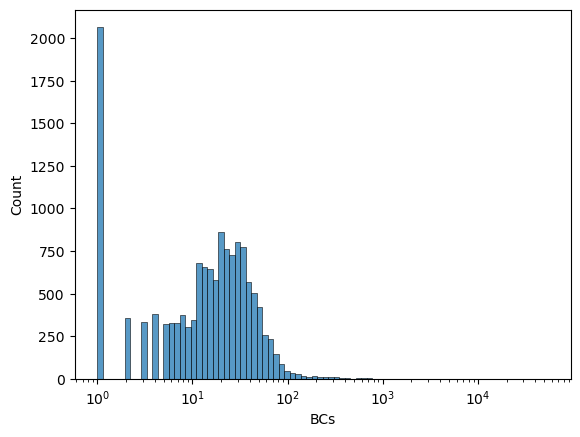

In [15]:
sns.histplot(data=rptr2_bcs_valuecounts, x='BCs', log_scale = True)
plt.show()

In [16]:
ad_tbcs = adbc_mapper(a1f)
ad_tbcs.head()

,Tiles,T Len,Designed,AD BCs,A Len,Tile-AD,Library
0,GGTGTTAAGAGAGCTTCTAAAGCATTTAAGACTTGTTTGTTCTGTA...,116,0,CCAGAAGTCCC,11,GGTGTTAAGAGAGCTTCTAAAGCATTTAAGACTTGTTTGTTCTGTA...,Staller_AD_E1_MVS_0070_I1
1,CAATCTGATAATCCATCTTCTGAAGCTAAGATTGTTTCTGATAGAC...,120,1,TTTCCGGAGCC,11,CAATCTGATAATCCATCTTCTGAAGCTAAGATTGTTTCTGATAGAC...,Staller_AD_E1_MVS_0070_I1
2,AAATTGGATCCAAATGTTGGTAGAGCTATTTCTAGAGCTAGAACTG...,120,1,TTCGTAGAAAC,11,AAATTGGATCCAAATGTTGGTAGAGCTATTTCTAGAGCTAGAACTG...,Staller_AD_E1_MVS_0070_I1
3,CCAAGATCTTCTTTGAATGAAGATTCTTTGTATCCTAAACCAAGAA...,120,1,AAACGTAGCAA,11,CCAAGATCTTCTTTGAATGAAGATTCTTTGTATCCTAAACCAAGAA...,Staller_AD_E1_MVS_0070_I1
4,ATTATGATCTTGGTTCAATTGATTAAGATTTCTAAATTGAATTATC...,120,1,TTTAGCGTTTT,11,ATTATGATCTTGGTTCAATTGATTAAGATTTCTAAATTGAATTATC...,Staller_AD_E1_MVS_0070_I1


In [17]:
bonus_mutants = ad_tbcs[(ad_tbcs['Designed']==0) & (ad_tbcs['T Len']==120)]
bonus_mutants.head()

,Tiles,T Len,Designed,AD BCs,A Len,Tile-AD,Library
17,ATTCCAACTGATTATCAGAATGAACCAGTTAATAAATCTGGTTCTA...,120,0,ACTCGGTGGAA,11,ATTCCAACTGATTATCAGAATGAACCAGTTAATAAATCTGGTTCTA...,Staller_AD_E1_MVS_0070_I1
97,GATAGATATGGTGGTAATGCTGATACATTTATCTTTGTCTTTCCAG...,120,0,AAACCTGCCCT,11,GATAGATATGGTGGTAATGCTGATACATTTATCTTTGTCTTTCCAG...,Staller_AD_E1_MVS_0070_I1
116,ATCTTCTATCCACAAGGTATTGAATTGGTTATTGAAAGATCTGATG...,120,0,GATCGGTCGGG,11,ATCTTCTATCCACAAGGTATTGAATTGGTTATTGAAAGATCTGATG...,Staller_AD_E1_MVS_0070_I1
133,ATTGGTTTGGTTAAATATATGTCTGAGAAGATTGGTTTGGGTAATA...,120,0,GATGCCAATAC,11,ATTGGTTTGGTTAAATATATGTCTGAGAAGATTGGTTTGGGTAATA...,Staller_AD_E1_MVS_0070_I1
199,GCTGCTCAAAGAGCATTTAGAGAAAGGAAATAAAGGAAGATGAAAG...,120,0,GGATTTGTCAC,11,GCTGCTCAAAGAGCATTTAGAGAAAGGAAATAAAGGAAGATGAAAG...,Staller_AD_E1_MVS_0070_I1


In [18]:
ad_tbcs = ad_tbcs.replace(0, np.nan)
ad_tbcs = ad_tbcs.dropna()
ad_tbcs.head()

,Tiles,T Len,Designed,AD BCs,A Len,Tile-AD,Library
1,CAATCTGATAATCCATCTTCTGAAGCTAAGATTGTTTCTGATAGAC...,120,1.0,TTTCCGGAGCC,11.0,CAATCTGATAATCCATCTTCTGAAGCTAAGATTGTTTCTGATAGAC...,Staller_AD_E1_MVS_0070_I1
2,AAATTGGATCCAAATGTTGGTAGAGCTATTTCTAGAGCTAGAACTG...,120,1.0,TTCGTAGAAAC,11.0,AAATTGGATCCAAATGTTGGTAGAGCTATTTCTAGAGCTAGAACTG...,Staller_AD_E1_MVS_0070_I1
3,CCAAGATCTTCTTTGAATGAAGATTCTTTGTATCCTAAACCAAGAA...,120,1.0,AAACGTAGCAA,11.0,CCAAGATCTTCTTTGAATGAAGATTCTTTGTATCCTAAACCAAGAA...,Staller_AD_E1_MVS_0070_I1
4,ATTATGATCTTGGTTCAATTGATTAAGATTTCTAAATTGAATTATC...,120,1.0,TTTAGCGTTTT,11.0,ATTATGATCTTGGTTCAATTGATTAAGATTTCTAAATTGAATTATC...,Staller_AD_E1_MVS_0070_I1
5,ACTACTAACTTTGATGGTTCTATTGCTATTTCTCCAGAATCTGCTG...,120,1.0,ATCCCAACCTC,11.0,ACTACTAACTTTGATGGTTCTATTGCTATTTCTCCAGAATCTGCTG...,Staller_AD_E1_MVS_0070_I1


In [19]:
adtile_vcs = ad_tbcs['Tiles'].value_counts().to_frame().reset_index()
adtile_vcs

,index,Tiles
0,CCAAGATCTTCTTTGAATGAAGATTCTTTGTATCCTAAACCAAGAA...,1385
1,CCACAATTGACTGCTCAACAATTGATTGAGAATGCTATTGAATCTG...,1258
2,AAGACTGAAGATGCTGTTAATGCTACTGCTACTGCTTCTGGTCCAT...,1188
3,TTGCCACCATTGACTCAATATATTCCACAAGCTGGTGGTATTCCAC...,1095
4,AATACTCCAGCTAATGTTATTGCTACTGATGCTACTAAATATGAAA...,950
...,...,...
6871,AATTATATGAAAGATTATCCATCTGATATGGCTAATTCTTCTTCTA...,1
6872,AGATCTAGAATTTATTGGGGTTGTTATATTGCTGATCACTTTATTT...,1
6873,AATTTGTTGCAAGAAAGAGAAAGAATTGAATTGGATTCTTGTGTTA...,1
6874,ATCTTCTTGCAATATATGGAGAATAAAGATATTCAATTGTTTATTC...,1


In [20]:
adtile_vcs.sum()

index    CCAAGATCTTCTTTGAATGAAGATTCTTTGTATCCTAAACCAAGAA...
Tiles                                               144295
dtype: object

In [21]:
adtile_vcs.describe()

,Tiles
count,6876.000000
mean,20.985311
std,44.541556
min,1.000000
25%,5.000000
50%,12.000000
75%,25.000000
max,1385.000000


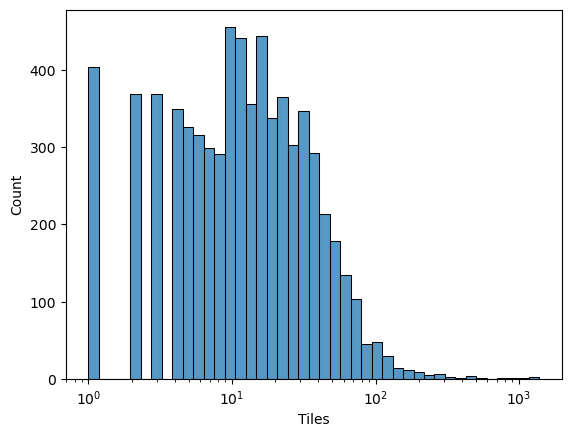

In [22]:
sns.histplot(data=adtile_vcs, x='Tiles', log_scale = True)
plt.show()

In [23]:
adbc_vcs = ad_tbcs['AD BCs'].value_counts().to_frame().reset_index()
adbc_vcs

,index,AD BCs
0,GTCCCCTTGCC,1231
1,TCGCCCAATCGT,1092
2,TCCGATGTGGG,1045
3,CTGCTGACCTA,553
4,TATGCGTCGTG,459
...,...,...
10190,GGGGGCTTGCG,1
10191,TCATCCTGACA,1
10192,CCGGGGTTCTT,1
10193,TTGCAATATGC,1


In [24]:
adbc_vcs[adbc_vcs['index']!= 'X'].sum()

index     GTCCCCTTGCCTCGCCCAATCGTTCCGATGTGGGCTGCTGACCTAT...
AD BCs                                               144289
dtype: object

In [25]:
adbc_vcs.describe()

,AD BCs
count,10195.000000
mean,14.153507
std,28.351605
min,1.000000
25%,3.000000
50%,8.000000
75%,17.000000
max,1231.000000


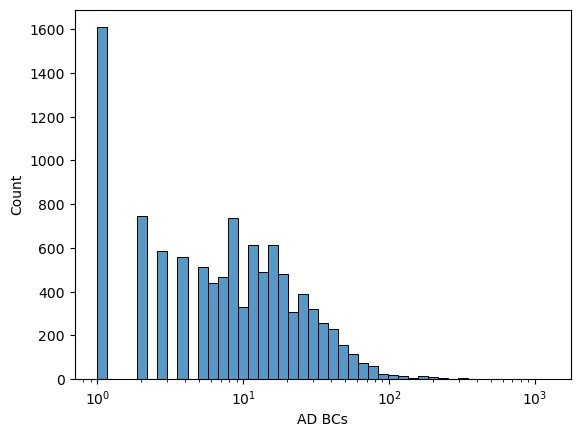

In [26]:
sns.histplot(data=adbc_vcs, x='AD BCs', log_scale = True)
plt.show()